# Bayesian Inference

In [1]:
# Load the relevant libraries
%matplotlib inline
import numpy as np
import scipy as sp
from scipy import stats
from scipy.stats import norm
import pandas as pd

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image

**Bayesian inference** is a method of statistical inference in which Bayes' rule is used to update the probability for a hypothesis as more evidence or information becomes available.


## Bayes' Rule
$$ p(B|A) = \frac{p(A|B)\,p(B)}{p(A)} $$ <br\>
This follows from the chain rule $ p(A,B) = p(B|A)\,p(A) = p(A|B)\,p(B) $ 

The first equality can be interpreted as follows. The **joint distribution**, p(A,B) is the product of the **marginal distribution** of A, p(A) and the conditioal distribution of B given A, p(B|A).

Bayes' theorem allows one to formally incorporate prior knowledge into computing statistical probabilities. 

### Example:
A patient has tested positive for a serious disease. The test is 99% accurate. The disease affects only 1 in 10,000 people. What is the probability that the patient actually has the disease?

Hypothesis, H=1: Patient has the disease.
Before the test, we have our prior probabilities $p(H=1) = 0.0001$ and $p(H=0) = 0.9999$.

The likelihood of the test being positive given that the patient has the disease is $p(T=1|H=1) = 0.99$ and likelihood of the test being negative given that the patient doesn't have the disease is $p(T=0|H=0) = 0.99$. Note that these are the probabilities of True Positive and True Negative, respectively. Also we have $p(T=1|H=0) = 1-p(T=0|H=0) = 1-0.99 = 0.01$

Data: Patient tested positive, $T = 1$.

Given this information, we update our prior belief of patient having the disease as follows:

$$ p(H=1|T=1) = \frac{p(T=1|H=1)\,p(H=1)}{p(T=1)} 
 = \frac{p(T=1|H=1)\,p(H=1)}{{p(T=1|H=0)\,p(H=0)}+{p(T=1|H=1)\,p(H=1)}} = 0.0098. $$

Thus, the probability that the patient actually has the disease is < 1%. Also, note that as expected by the positive test result, the posterior probability is higher that the prior probability.

## Bayesian Inference

Bayesian inference ivolves the following steps:
1. Write down the **likelihood function** of the data.
2. Form a **prior distribution** over all unknown parameters.
3. Use Bayes theorem to find the **posterior distribution** over all parameters.

<img src="./figures/Bayes_rule_schematic.png" alt="Drawing" style="width: 300px;">

where, 

$y$: data/observations 

$\theta$: vector of parameters for our **hypothesis** 

$p(y|\theta)$: likelihood of y 

$p(y)$: marginal probability of y 

$p(\theta)$: prior distribution of $\theta$ 

$p(\theta|y)$: posterior distribution of $\theta$ 


Thus it can be read as:

$$ Posterior = \frac{Likelihood \times Prior }{Evidence} $$


* In contrast to **Frequentist approach**, where we treat $\theta$ as a fixed value, in **Bayesian approach** we treat $\theta$ as a random variable, having prior distribution $p(\theta)$.
* Prior distribution tells us our belief on values of $\theta$ before we observe any data.
* The goal of Bayesian inference is to calculate the posterior distribution $p(\theta|y)$, which is the updated distribution of $\theta$ taking into account the observed data $y$.
* $p(y$) is independent of $\theta$, so we can write
$$p(\theta|y) \propto p(y|\theta)\,p(\theta)$$
* **This posterior distribution up to a normalizing constant is sufficient for MCMC sampling.**

## Conjugate Priors
The prior is called a conjugate prior for the likelihood function if the posterior distribution $p(\theta|y)$ is in the same family as the prior distribution $p(\theta)$.

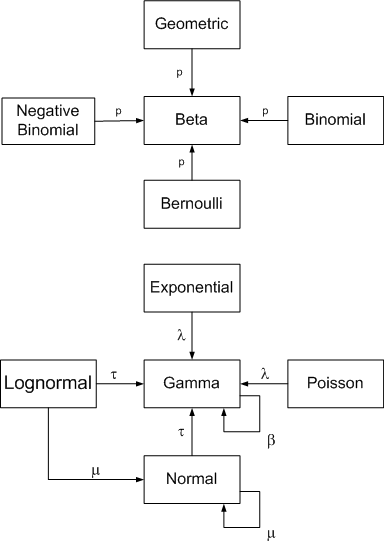

In [2]:
Image("./figures/conjugate_prior_diagram_john_cook.png")
# Credit: John D. Cook. https://www.johndcook.com/blog/conjugate_prior_diagram/

### Example 1: Beta-Binomial
$p(\theta) \sim Beta(a,b)$ is conjugate prior for the likelihood $p(y|\theta) \sim Binomial(N,\theta)$. <br>


**Proof**: <br>
Data: $y = (y_1, ..., y_n)$, where $y_i$'s are independent and identically distributed (iid) observations such that $y_i \sim Binomial(N_i,\theta)$

The likelihood function and prior distribution can be written as 
$$p(y|\theta) = \prod_{i=1}^{n} p(y_i|\theta) 
= \prod_{i=1}^{n} \left( \begin{array}{cccc} N_i\\ y_i \\ \end{array} \right) \, \theta^{y_i} \, (1-\theta)^{1-y_i} 
\propto \theta^{\sum_{i=1}^{n} y_i} \, (1-\theta)^{\sum_{i=1}^{n} N_i-y_i} 
= \theta^{n\bar{y}} \, (1-\theta)^{n\bar{N}-n\bar{y}}$$

$$ p(\theta) = \frac{\Gamma(a+b)}{\Gamma(a) \, \Gamma(b)} \, \theta^{a-1} \, (1-\theta)^{b-1}$$

Thus our posterior distribution becomes
$$ p(\theta|y) \propto p(y|\theta)\,p(\theta) 
\propto \theta^{n\bar{y} + a - 1} \, (1-\theta)^{n(\bar{N}-\bar{y}) + b - 1} 
\propto Beta(a+n\bar{y}, \, b+n(\bar{N}-\bar{y})) $$

This has a nice **intuitive interpretation**. We can think of $a$ as prior number of successes and $b$ as prior number of failures. So, according to our prior distribution, we had $a$ success and $b$ failures in the past. In our experiment, we observe $n\bar{y}$ more sucesses and $n(\bar{N}-\bar{y})$ more failures. So we just add the number of successes and the number of failures to obtain the posterior distribution.

Now we can radily obtain key statistics as follows: 


**Posterior Mean (PM) Estimator**:
$$ \hat{\theta}_{PM} = \frac{a+n\bar{y}}{a+b+n\bar{N}} $$

## Rat Tumor Example (from Gelman, chapter 5)
### Estimating the risk of tumor in a group of rats

Suppose that our goal is to estimate $\theta$, the probability of tumor in a population of rats that receive a zero dose of a particular drug (control group). 

Historical data:
The historical data contains a set of observations of tumor incidence in 70 different experiments. <br/>
y: number of rats that get the tumor <br/>
N: total number of rats tested

Now a 71st experiment is done and it is found that 4 out of 14 rats developed tumors. What is the probability of tumor in the 71st expriment.

In [3]:
# Historical data 
y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 2, 2, 
              2, 2, 2, 2, 2, 2, 1, 5, 2, 5, 2, 7, 7, 3, 3, 2, 9, 10, 4, 4, 4, 4, 4, 4, 4, 
              10, 4, 4, 4, 5, 11, 12, 5, 5, 6, 5, 6, 6, 6, 6, 16, 15, 15, 9])
N = np.array([20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 18, 18, 17, 20, 20, 20, 20, 19, 19, 
              18, 18, 27, 25, 24, 23, 20, 20, 20, 20, 20, 20, 10, 49, 19, 46, 17, 49, 47, 20, 
              20, 13, 48, 50, 20, 20, 20, 20, 20, 20, 20, 48, 19, 19, 19, 22, 46, 49, 20, 20, 
              23, 19, 22, 20, 20, 20, 52, 46, 47, 24])
print (len(y))

70


It is reasonable to assume a binomial model for the number of rats with tumors. Thus our **likelihood** function is given by 
$$p(y|\theta) \sim Binomial(N,\theta) $$

For convenience, we select a conjugate **prior** distribution for theta
$$ p(\theta) \sim Beta(a,b) $$

Thus our **posterior** distribution for $\theta$ becomes
$$p(\theta|y) \sim Beta(a+y, b+N-y) $$

We use historical data to estimte parameters $(a,b)$ for our prior distribution. This approach is called **Empirical Bayes**. The observed probabilities of tumor formation in an experiment is $y_i/N_i$. The observed sample mean and variance of the 70 values of $y_i/N_i$ are $\mu=0.136$ and $s2=0.103$ (see the following calculation).

In [4]:
# Approximate estimate of the population distribution using the historical data.
mu = np.mean(1.0*y/N)
sig2 = np.var(1.0*y/N)
s2 = (70.0/(70-1))*np.var(1.0*y/N) # Sample mean s2=(N/(N-1))*sig2
print ('mu = {:.3f}, sig2 = {:.3f}, s2 = {:.3f}'.format(mu,sig2,s2))

mu = 0.136, sig2 = 0.011, s2 = 0.011


Now we set mean and variance of our prior distribution ($Beta(a,b)$) to these values and solve for a and b as follows:
$$ \frac{a}{a+b} = \mu $$
$$ \frac{ab}{(a+b)^2(a+b+1)} = s2 $$
Solving these two eqautions, we get
$$ a = \mu^2 \, \left(\frac{1-\mu}{s2} - \frac{1}{\mu}\right) $$
$$ b = a \, \left(\frac{1}{\mu} - 1\right) = \mu^2 \, \left(\frac{1-\mu}{s2} - \frac{1}{\mu}\right) \, \left(\frac{1}{\mu} - 1\right) $$

In [5]:
a = mu*(mu*(1-mu)/s2-1)
b = a*(1-mu)/mu
print ('a = {:.3f}, b = {:.3f}'.format(a, b))

a = 1.356, b = 8.615


In [6]:
# Thus our posterior becomes Beta(1.4+4, 8.6+14-4) = Beta(5.4,18.6)
print ('mean and standard deviation of prior distribution \
{:.3f}, {:.3f}'.format(stats.beta.mean(a=1.4, b=8.6), 
       stats.beta.std(a=1.4, b=8.6)))
print ('mean and standard deviation of posterior distribution \
{:.3f}, {:.3f}'.format(stats.beta.mean(a=5.4, b=18.6), \
                       stats.beta.std(a=5.4, b=18.6)))

mean and standard deviation of prior distribution 0.140, 0.105
mean and standard deviation of posterior distribution 0.225, 0.084


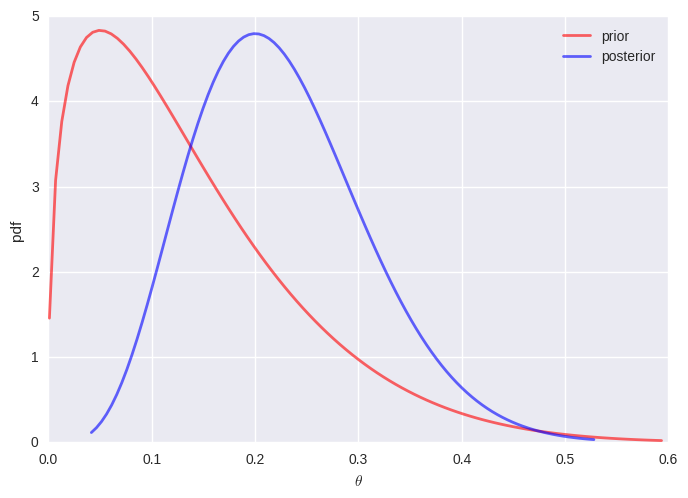

In [7]:
# Plot prior Beta(1.4,8.6) and posterior Beta(5.4,18.6) distributions
def plot_beta(a,b,color,label):
    x = np.linspace(stats.beta.ppf(0.001, a, b),
                    stats.beta.ppf(0.999, a, b), 100)
    plt.plot(x, stats.beta.pdf(x, a, b),
             c=color, lw=2, alpha=0.6, label=label)
    
plot_beta(1.4,8.6,'r','prior')
plot_beta(5.4,18.6,'b','posterior')
plt.legend(loc='best')
plt.xlabel(r'$\theta$')
plt.ylabel('pdf');

### Bayesian Logistic Regression 
Now let's look at an example of a nonconjegate model where the normalization of the posterior distribution cannot be obtained using analytical methods. Specifically, we will consider Bayesian Logistic Regression. 

### Bioassay example from Gelman, chapter 3
#### The scientific problem and the data
As shown in the table below, different doses (log g/ml) of a drug were administered to 20 animals and a binary outcome (alive or dead) is noted. Our goal is to model the dose-response relation. 

In [8]:
x = np.array([-0.86, -0.86, -0.86, -0.86, -0.86, 
              -0.3,  -0.3,  -0.3,  -0.3,  -0.3, 
              -0.05, -0.05, -0.05, -0.05, -0.05,  
               0.73,  0.73,  0.73,  0.73,  0.73])
y=np.array([0,0,0,0,0,
            0,0,0,0,1,
            0,0,1,1,1,
            1,1,1,1,1])
df = pd.DataFrame({'Dose': x, 'Response': y})
df

,Dose,Response
0,-0.86,0
1,-0.86,0
2,-0.86,0
3,-0.86,0
4,-0.86,0
5,-0.30,0
6,-0.30,0
7,-0.30,0
8,-0.30,0
9,-0.30,1


### Model:
#### Data: 
$y = ((x_1,y_1), (x_2,y_2), ..., (x_n,y_n))$
#### Likelihood:
We model $y$ as a Bernoulli random variable. The likelihood function can be written as 
$$p(y|x, \theta) = \prod_{i=1}^{n} p(y_i|x_i, \theta_i) 
= \prod_{i=1}^{n} \theta_i^{y_i} \, (1-\theta_i)^{1-y_i} $$
where, the rate of deaths is given by
$$ \theta_i = \frac{1}{1+e^{-(\alpha+\beta x_i)}}$$
#### Priors:
Here, we will use Gaussian priors for both parameters $\alpha=\mathcal{N}(\mu=0,\sigma=100)$ and $\beta=\mathcal{N}(\mu=0,\sigma=100)$. The joint prior distribution is given by
$$ p(\alpha\beta) = p(\alpha)p(\beta) $$
where,
$$ p(\alpha) = \frac{1}{\sqrt{2\pi\sigma^2}}
            e^{-\frac{\alpha^2}{2\sigma^2}} \text{   and}$$
$$ p(\beta) = \frac{1}{\sqrt{2\pi\sigma^2}}
            e^{-\frac{\beta^2}{2\sigma^2}}$$
#### Posterior:
Thus the posterior distribution of $\alpha$ and $\beta$ becomes
$$ p(\alpha,\beta|x,y) \propto \bigg(\prod_{i=1}^{n} \theta_i^{y_i} \, 
                                        (1-\theta_i)^{1-y_i} \bigg)
                          p(\alpha)p(\beta)$$
#### Log-posterior:
In our implementation of the Metropolis-Hastings algorithm, we use log-posterior. This leads to a numerically more stable implementation.
$$ log\,p(\alpha,\beta|x,y) \propto 
\sum_{i=1}^{n} \bigg(y_i log(\theta_i)+(1-y_i)log(1-\theta_i)\bigg)
-\frac{1}{2\sigma^2}(\alpha^2+\beta^2)$$
Also, note that, the last term in the above expression is analogous to the regularization term in the frequentist version of logistic regression.

In [9]:
## sigmoid
sigmoid = lambda x: 1/(1.0+np.exp(-x))

## posterior
def calc_log_posterior(alpha, beta, x=x, y=y):    
    # Priors on alpha, beta
    logprior = (norm.logpdf(alpha, loc=0, scale=100) + 
                norm.logpdf(beta, loc=0, scale=100))
    # Likelihood
    loglik = np.sum(y*np.log(sigmoid(alpha+beta*x)) + 
                   (1-y)*np.log(1.0-sigmoid( alpha+beta*x)))
    # Posterior
    logp = loglik + logprior    
    return logp

### Sampling using MCMC
Markov chain Monte Carlo (MCMC) methods are a class of algorithms for sampling from a probability distribution based on constructing a Markov chain that has the desired distribution as its stationary distribution. MCMC allows for efficient sampling from the posterior distributions that are intractable using analytic approaches, which is often the case.

We will use the Metropolis-Hastings algorithm, which is a popular MCMC method, to sample from our posterior distribution.

More efficient implemetations of MCMC can be found in [PyMC3](https://pymc-devs.github.io/pymc3/index.html). **PyMC3** is a Python package for Bayesian statistical modeling and Probabilistic Machine Learning which focuses on advanced MCMC and variational fitting algorithms.

In [10]:
# this code is taken from https://github.com/fonnesbeck/Bios8366/blob/master/notebooks/Section4_2-MCMC.ipynb

rnorm = np.random.normal
runif = np.random.rand

def metropolis(n_iterations, initial_values, prop_std=[1,1], doPrint=True):
    #################################################################
    # function to sample using Metropolis 
    # (assumes proposal distribution is symmetric)
    # 
    # n_iterations:  number of iterations
    # initial_values: multidimensional start position for our chain
    # prop_std: standard deviation for Gaussian proposal distribution 
    ##################################################################
    
    #np.random.seed(seed=1)
    n_params = len(initial_values)
            
    # Initial proposal standard deviations
    # generates a list of length n_params
    #prop_sd = [prop_std]*n_params
    prop_sd = prop_std
    
    # Initialize trace for parameters
    trace = np.empty((n_iterations+1, n_params))
    
    # Set initial values
    trace[0] = initial_values
        
    # Calculate joint posterior for initial values
    # the * assigns the arguments of the function according to the list elements
    #current_prob = calc_posterior(*trace[0])
    current_log_prob = calc_log_posterior(*trace[0])
    
    # Initialize acceptance counts
    # We can use this to tune our step size
    accepted = [0]*n_params
    
    for i in range(n_iterations):
    
        if not i%10000 and doPrint: 
            print('Iterations remaining: ', n_iterations-i)
    
        # Grab current parameter values
        current_params = trace[i]
    
        # Get current value for parameter j
        p = trace[i].copy() 
        
        # loop over all dimensions
        for j in range(n_params):
            # proposed new value
            theta = rnorm(current_params[j], prop_sd[j])
            
            # Insert new value 
            p[j] = theta
    
            # Calculate posterior with proposed value
            #proposed_prob = calc_posterior(*p)
            proposed_log_prob = calc_log_posterior(*p)
    
            # Log-acceptance rate
            #alpha = proposed_prob/current_prob
            alpha = proposed_log_prob-current_log_prob
    
            # Sample a uniform random variate
            u = runif()
    
            # Test proposed value
            if np.log(u) < alpha:
                # Accept
                trace[i+1,j] = theta
                current_log_prob = proposed_log_prob
                accepted[j] += 1
            else:
                # Stay put
                trace[i+1,j] = trace[i,j]
            
            # update p so we search the next dimension according
            # to the current result
            p[j] = trace[i+1,j]
    
    # return our samples and the number of accepted steps
    return trace, accepted

In [11]:
n_iter = 25000
trace, acc = metropolis(n_iter, [10,20], [3.0,10.0]) #[3.0,12.0])
acc/np.double(n_iter)
print ('Fraction of accepted samples of alpha = {:.3f}'.format(acc[0]/np.double(n_iter)))
print ('Fraction of accepted samples of beta = {:.3f}'.format(acc[1]/np.double(n_iter)))

('Iterations remaining: ', 25000)
('Iterations remaining: ', 15000)
('Iterations remaining: ', 5000)
Fraction of accepted samples of alpha = 0.319
Fraction of accepted samples of beta = 0.419


Let's examin the trace plot (the values the parameter took during the runtime of the chain) of $\alpha$ and $\beta$.

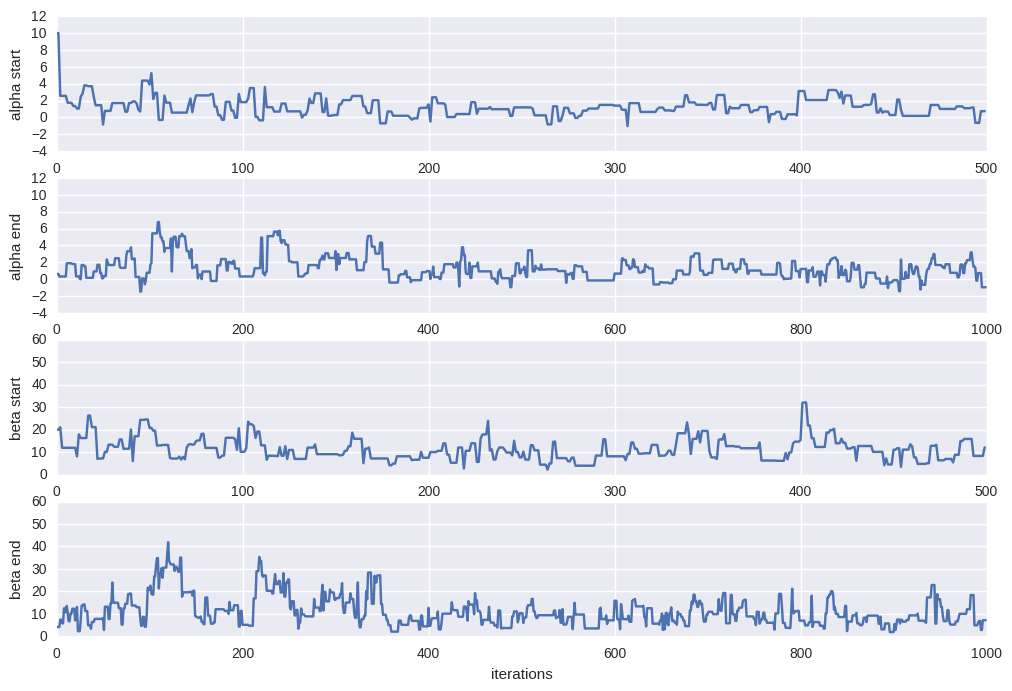

In [12]:
plt.figure(figsize=[12,8])

burnin = 500
#alpha = trace[burnin:,0]; beta=trace[burnin:,1]
alpha = trace[:,0]; beta=trace[:,1]

# trace plot for alpha during burnin
plt.subplot(4,1,1) 
plt.plot(trace[:burnin,0])
plt.ylim(-4,12)
plt.xlabel("iterations")
plt.ylabel("alpha start")

# trace plot for alpha at the end 
# where we hopefully converged
plt.subplot(4,1,2) 
plt.plot(alpha[-2*burnin:])
plt.ylim(-4,12)
plt.xlabel("iterations")
plt.ylabel("alpha end")

# trace plot for beta during burnin
plt.subplot(4,1,3) 
plt.plot(trace[:burnin,1])
plt.ylim(0,60)
plt.xlabel("iterations")
plt.ylabel("beta start")

# trace plot for beta at the end 
# where we hopefully converged
plt.subplot(4,1,4) 
plt.plot(beta[-2*burnin:])
plt.ylim(0,60)
plt.xlabel("iterations")
plt.ylabel("beta end")

In [13]:
burnin = 5000 # throw away the burnin samples
newtrace = trace[burnin:,]
alpha = trace[burnin:,0]; beta=trace[burnin:,1]

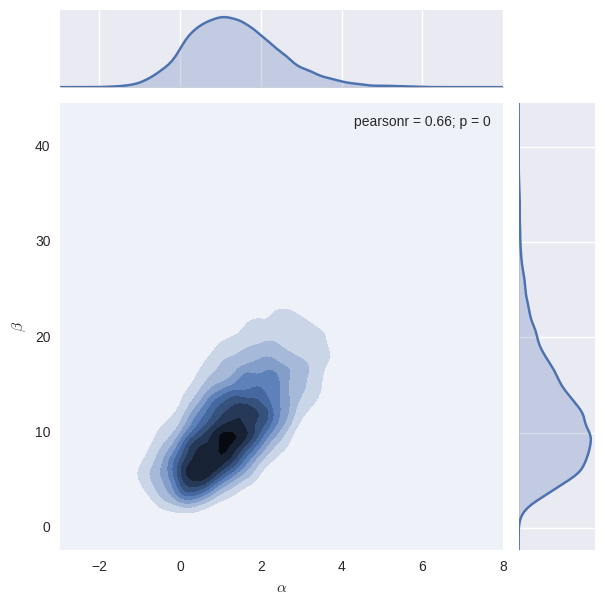

In [14]:
g = (sns.jointplot(alpha, beta, kind="kde", n_levels=10)
     .set_axis_labels(r"$\alpha$", r"$\beta$"))

References: 
* [Bayesian Data Analysis, Andrew Gelman](http://www.stat.columbia.edu/~gelman/book/) 
* [STAT 111](http://isites.harvard.edu/icb/icb.do?keyword=k101665), [AM207](http://iacs-courses.seas.harvard.edu/courses/am207/index.html), and [CS109](http://cs109.github.io/2015/) at Harvard